# Projet : ATT spam detector
# Modèle 1 : "Base Line"

## Import Modules

In [75]:
import pandas as pd
import numpy as np

import re
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split
import tensorflow as tf

import matplotlib.pyplot as plt

## Chargement et exploration des données

In [ ]:
df = pd.read_csv("./data/spam.csv", encoding="cp1252")

print(df.shape)
display(df.head())

(5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [77]:
df.drop(columns="Unnamed: 2", inplace=True)
df.drop(columns="Unnamed: 3", inplace=True)
df.drop(columns="Unnamed: 4", inplace=True)

df.drop_duplicates(inplace=True)

df.rename(columns={"v1": "sms_class"}, inplace=True)
df.rename(columns={"v2": "sms_brut"}, inplace=True)

print(df.shape)
display(df.head())

(5169, 2)


,sms_class,sms_brut
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: ylabel='count'>

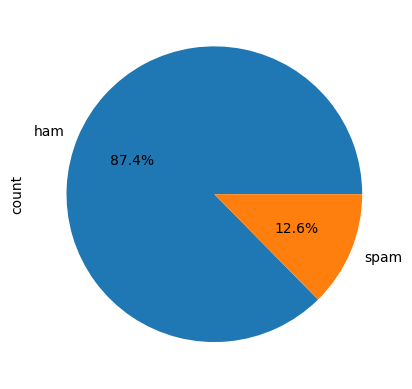

In [78]:
df["sms_class"].value_counts().plot.pie(autopct="%1.1f%%")

In [79]:
display(df[df["sms_class"] == "ham"].head()) 

,sms_class,sms_brut
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
6,ham,Even my brother is not like to speak with me. ...


In [80]:
display(df[df["sms_class"] == "spam"].head()) 

,sms_class,sms_brut
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


## Nettoyage des données

In [81]:
# Suppression des ponctuations et passage en miniscules 

df["sms_clean"] = df["sms_brut"].apply(lambda text: re.sub("[!\"#$%&()*+,-./:;<=>?@\[\]^_`{|}~\\\]+"," ", text)) 
df["sms_clean"] = df["sms_clean"].fillna("").apply(lambda text: text.lower())

print(df.shape)
display(df.head())

(5169, 3)


,sms_class,sms_brut,sms_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives aro...


## Tokenirisation

In [82]:
nlp = en_core_web_sm.load()

# Tokenirization
df["sms_tokenized"] = df["sms_clean"].fillna("").apply(lambda x: nlp(x))

# suppression stop-words et remplacement des mots par les lemma
df["sms_tokenized"] = df["sms_tokenized"].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])

# clean up tokenized documents
df["sms_clean_tokens"] = [" ".join(x) for x in df["sms_tokenized"]]

# sms_class => 1 spam et 0 pour ham
df["sms_class"] = df["sms_class"].map({"ham":0,"spam":1})

print(df.shape)
display(df.head())

(5169, 5)


,sms_class,sms_brut,sms_clean,sms_tokenized,sms_clean_tokens
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...,"[jurong, point, , crazy, , available, bugis,...",jurong point crazy available bugis n great...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, , joke, wif, u, oni]",ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, early, hor, , u, c]",u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives aro...,"[nah, think, go, usf, , live]",nah think go usf live


## Encodage

In [83]:
# Prise en compte des 1000 mots les plus frequents dans la tokenirisation
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="_OOV_") 
tokenizer.fit_on_texts(df["sms_clean_tokens"])
df["sms_encoded"] = tokenizer.texts_to_sequences(df["sms_clean_tokens"])

print(df.shape)
display(df.head())

(5169, 6)


,sms_class,sms_brut,sms_clean,sms_tokenized,sms_clean_tokens,sms_encoded
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...,"[jurong, point, , crazy, , available, bugis,...",jurong point crazy available bugis n great...,"[1, 253, 446, 469, 922, 37, 60, 272, 923, 75, ..."
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, , joke, wif, u, oni]",ok lar joke wif u oni,"[14, 207, 496, 301, 2, 1]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...,"[15, 373, 3, 763, 716, 46, 1, 1, 497, 1, 1, 1,..."
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, early, hor, , u, c]",u dun early hor u c,"[2, 129, 154, 1, 2, 56]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives aro...,"[nah, think, go, usf, , live]",nah think go usf live,"[717, 24, 5, 660, 175]"


## "Padding"

In [84]:
sms_padded = tf.keras.preprocessing.sequence.pad_sequences(df["sms_encoded"], padding="post")
print(sms_padded)
print(sms_padded.shape)

[[  1 253 446 ...   0   0   0]
 [ 14 207 496 ...   0   0   0]
 [ 15 373   3 ...   0   0   0]
 ...
 [  1   1   1 ...   0   0   0]
 [121   1   1 ...   0   0   0]
 [  1 368   0 ...   0   0   0]]
(5169, 77)


## Splitter le dataset : train / test

In [85]:
X_train, X_test, y_train, y_test = train_test_split(sms_padded, df["sms_class"], test_size = 0.2, stratify = df["sms_class"], random_state = 42)

## Création des Tensors et Batch

In [86]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_batch = train_ds.shuffle(len(train_ds)).batch(64)
test_batch = test_ds.shuffle(len(test_ds)).batch(64)

## Modèle de base

In [87]:
sequence_length = sms_padded.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.num_words + 1, 8, input_shape=[sequence_length], name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [88]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 77, 8)             8008      
                                                                 
 global_average_pooling1d_3   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 32)                288       
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8,329
Trainable params: 8,329
Non-trainable params: 0
_________________________________________________________________


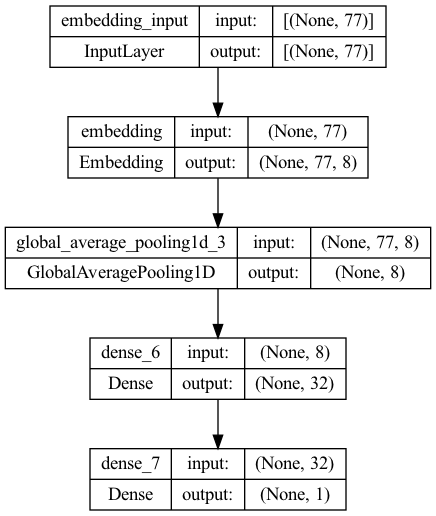

In [89]:
tf.keras.utils.plot_model(model, "./model0.png", show_shapes=True)

In [90]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision"), "accuracy"]
)

In [91]:
history = model.fit(
    train_batch,
    epochs = 50,
    validation_data=test_batch
)

Epoch 1/50
65/65 [==============================] - 0s 2ms/step - loss: 0.6521 - recall: 0.0747 - precision: 0.1083 - accuracy: 0.8056 - val_loss: 0.5967 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8733
Epoch 2/50
65/65 [==============================] - 0s 557us/step - loss: 0.5214 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8738 - val_loss: 0.4387 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8733
Epoch 3/50
65/65 [==============================] - 0s 525us/step - loss: 0.3839 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8738 - val_loss: 0.3534 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8733
Epoch 4/50
65/65 [==============================] - 0s 529us/step - loss: 0.3429 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8738 - val_loss: 0.3390 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8733
Epoch 5/50
65/65 [==============================] 

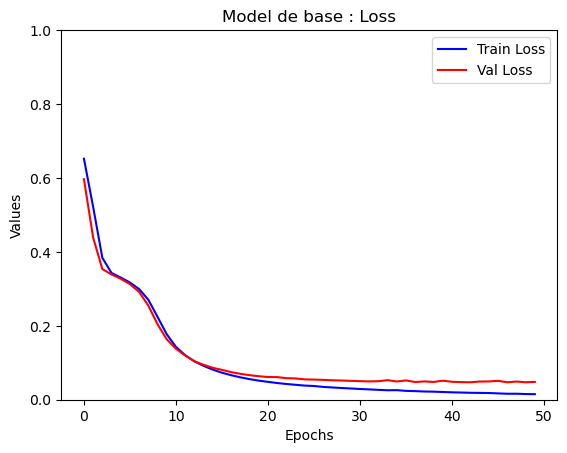

In [92]:
plt.plot(history.history["loss"], color="b", label="Train Loss")
plt.plot(history.history["val_loss"], color="r", label="Val Loss")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Model de base : Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

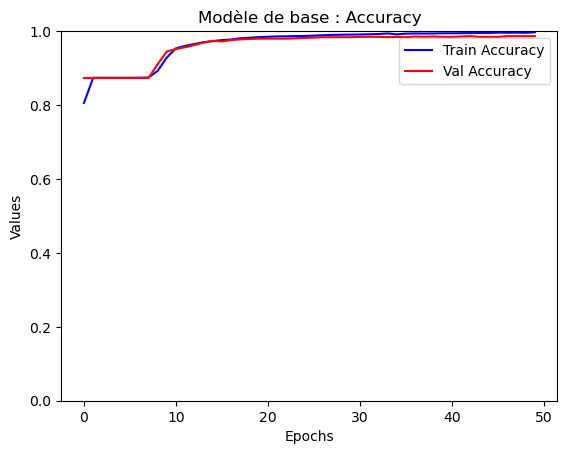

In [93]:
plt.plot(history.history["accuracy"], color="b", label="Train Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Val Accuracy")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Modèle de base : Accuracy")
plt.legend()
plt.ylim(0,1)
plt.show()

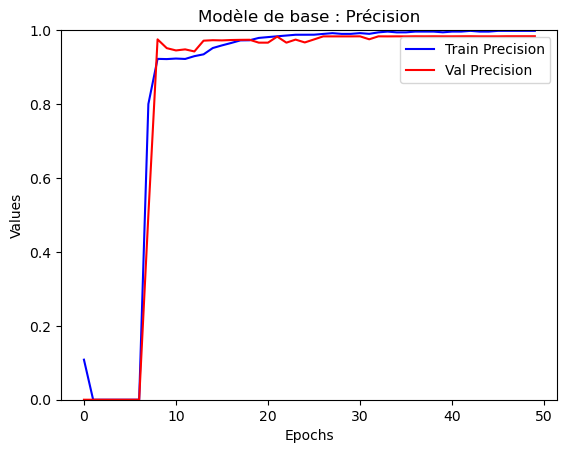

In [94]:
plt.plot(history.history["precision"], color="b", label="Train Precision")
plt.plot(history.history["val_precision"], color="r", label="Val Precision")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Modèle de base : Précision")
plt.legend()
plt.ylim(0,1)
plt.show()

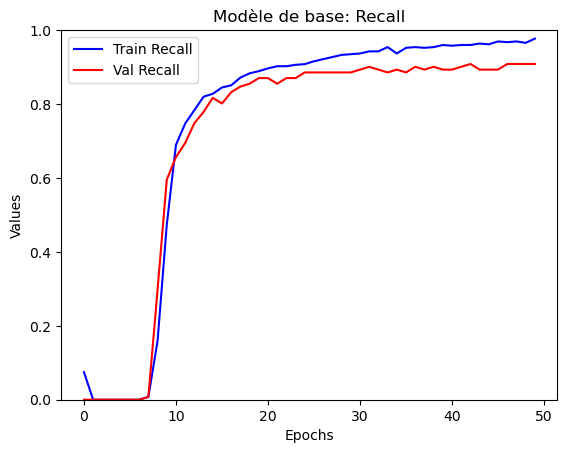

In [95]:
plt.plot(history.history["recall"], color="b", label="Train Recall")
plt.plot(history.history["val_recall"], color="r", label="Val Recall")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Modèle de base: Recall")
plt.legend()
plt.ylim(0,1)
plt.show()

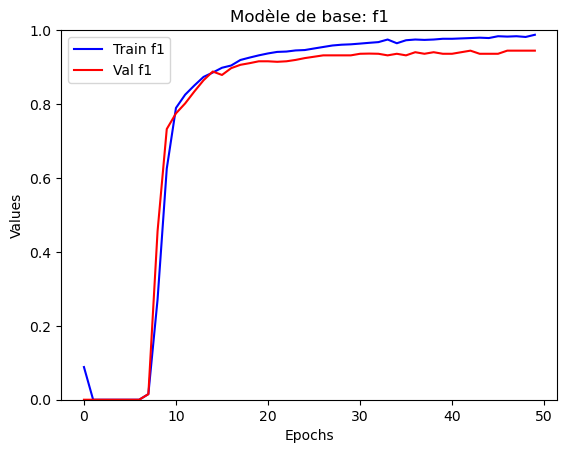

In [96]:
recall = history.history["recall"]
precision = history.history["precision"]

f1 = pd.DataFrame()
f1["f1"] =  2*np.array(recall)*np.array(precision)/(np.array(recall)+np.array(precision)+tf.keras.backend.epsilon())

val_recall = history.history["val_recall"]
val_precision = history.history["val_precision"]

val_f1 = pd.DataFrame()
val_f1["val_f1"] =  2*np.array(val_recall)*np.array(val_precision)/(np.array(val_recall)+np.array(val_precision)+0.00000001)

plt.plot(f1["f1"], color="b", label="Train f1")
plt.plot(val_f1["val_f1"], color="r", label="Val f1")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Modèle de base: f1")
plt.legend()
plt.ylim(0,1)
plt.show()



### Synthèse résultat modele de base "Custom deep learning"

In [97]:
print("**Train :")
print("Loss :", list(history.history["loss"])[-1])
print("Accuracy :", list(history.history["accuracy"])[-1])
print("precision :", list(history.history["precision"])[-1])
print("Recall :", list(history.history["recall"])[-1])
print("f1 :", list(f1["f1"])[-1])
print()
print("**Test :")
print("Loss :", list(history.history["val_loss"])[-1])
print("Accuracy :", list(history.history["val_accuracy"])[-1])
print("precision :", list(history.history["val_precision"])[-1])
print("Recall :", list(history.history["val_recall"])[-1])
print("f1 :", list(val_f1["val_f1"])[-1])

**Train :
Loss : 0.014997489750385284
Accuracy : 0.9968560934066772
precision : 0.9980430603027344
Recall : 0.977011501789093
f1 : 0.9874152527645039

**Test :
Loss : 0.0481211356818676
Accuracy : 0.9864603281021118
precision : 0.9834710955619812
Recall : 0.9083969593048096
f1 : 0.9444444561049007
